### Example applications of F and chi-square tests of variance
Elizabeth Maroon, 7/16/2021 <br>
Adapted from AOS 575 materials


In [1]:
import numpy as np
from scipy.stats import f, norm, chi2
import matplotlib.pyplot as plt

#### F-statistic

The F-statistic can be used to compare two sample standard deviations $s_1$ and $s_2$ from samples of size $N_1$ and $N_2$.  It assumes that the two samples are taken from underlying normal populations.  If the populations are not normal, the F-test will likely fail because it is *very sensitive to normality*. Wilks states that a *permutation test* is a more reliable way to test sample differences for a complicated statistic like variance and isn't any harder to compute than an f-test (Wilks textbook, pp169-172). 

Random variable $F$,

\begin{equation}
F = \frac{s_1^2}{s_2^2},
\end{equation}

is compared to the F-distribution using the parameters $\nu_1$ and $\nu_2$, the degrees of freedom for the two samples.

In [2]:
#constructing two test time series of the same length
x1 = np.random.normal(loc=0.0, scale=1.0, size=100)
x2 = np.random.normal(loc=0.0, scale=2, size=100) 
#x2 has standard deviation 2x that of x1 (scale) by design
#time series are not required to be same length - dof below accounts for that
#loc = mean for distribution, here centered at 0.

In [3]:
#calculate means and variances
mu1 = np.mean(x1)
mu2 = np.mean(x2)

var1 = np.var(x1, ddof = 1) #setting DOF to N-1 b/c sample variance not pop variance
var2 = np.var(x2, ddof = 1) #setting DOF to N-1 b/c sample variance not pop variance

print('sample 1 mean:', mu1)
print('sample 1 variance:', var1)
print()
print('sample 2 mean:', mu2)
print('sample 2 variance:', var2)



sample 1 mean: 0.16733089871925952
sample 1 variance: 0.829555502045668

sample 2 mean: -0.0022216687028138614
sample 2 variance: 4.42306495474155


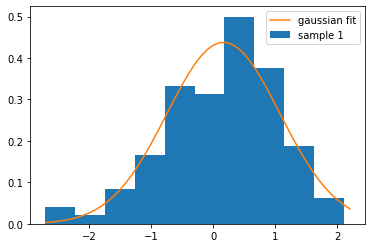

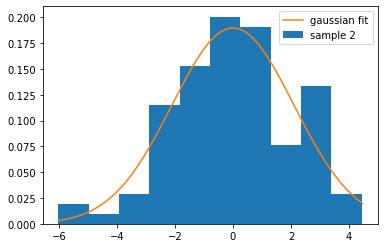

In [4]:
#check visually that the two samples at least appear Gaussian. 
#Doing something like a Kolmogorov-Smirnov test would be a more objective way to do this...
plt.figure()
plt.hist(x1, density = True, label='sample 1')
xrange = np.arange(np.min(x1), np.max(x1)+0.1, 0.1)
plt.plot(xrange, norm.pdf(xrange, mu1, np.sqrt(var1)), label='gaussian fit')
plt.legend()

plt.figure()
xrange = np.arange(np.min(x2), np.max(x2)+0.1, 0.1)
plt.hist(x2, density = True, label='sample 2')
plt.plot(xrange, norm.pdf(xrange, mu2, np.sqrt(var2)), label='gaussian fit')
plt.legend()

In [6]:
# Use Kolmogorov-Smirnov normality test:
# compare our data sample with a TRUE normal
import scipy.stats as stats
D, p = stats.kstest(x1,'norm')
print('x1:  Max. Difference = ' + str(D) + ', p-value = ' + str(p))
D, p = stats.kstest(x2,'norm')
print('x2:  Max. Difference = ' + str(D) + ', p-value = ' + str(p))

x1:  Max. Difference = 0.1361100216491875, p-value = 0.044587556750829975
x2:  Max. Difference = 0.21001978411137656, p-value = 0.00023906536465364013


In [5]:
#calculate f-stat for the two samples
fstat = var1/var2
print('F-statistic:',fstat)

#dof for both samples
dof1 = len(x1)-1 
dof2 = len(x2)-1 

#p value of this f-statistic
p = f.cdf(fstat, dof1, dof2) #p-value of F statistic 

#set significance
alpha = 0.025 #two tailed, 95%
print('p value:', p)

#Do test
if (1-p<alpha) or p<alpha: 
    print('null hypothesis rejected: variances are statistically different to 95% confidence.')
else: 
    print('cannot reject null hypothesis: variances are not statistically different to 95% confidence.')
    

F-statistic: 0.24626867737245473
p value: 1.0577726440922956e-11
null hypothesis rejected: variances are statistically different to 95% confidence.


#### Visual Demonstration

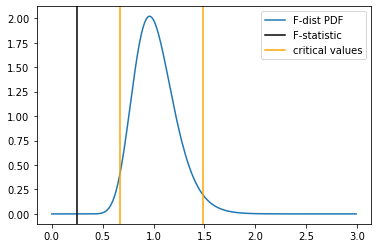

In [6]:
xrange = np.arange(0,3,0.01)
fdist = f.pdf(xrange,dof1,dof2)
lowerbound = f.ppf(alpha,dof1,dof2)
upperbound = f.ppf(1-alpha,dof1,dof2)

plt.plot(xrange, fdist, label = 'F-dist PDF')
plt.axvline(fstat, label = 'F-statistic', color='black')
plt.axvline(lowerbound, label = 'critical values', color = 'orange')
plt.axvline(upperbound, color = 'orange')
plt.legend()

If the two standard deviations are statistically distinct and $s_1$ (numerator) < $s_2$ (denominator), then $F$ will appear in the LHS tail of the F-distribution.  If $s_1$ > $s_2$, then $F$ will be in RHS tail.

#### Adjusting DOF for filtering
I assume that the DOF of the samples need to be adjusted if there's autocorrelation and/or filtering has been applied. The effective sample size ($N^*$) of Leith (1973) is

\begin{equation}
N^* = N \frac{\ln(\rho(1))}{-2},
\end{equation}

where $\rho(1)$ is the lag-one autocorrelation. See Hartmann's notes for other effective sample approaches (https://atmos.uw.edu/~dennis/552_Notes_6a.pdf). I suspect that low pass filtering may break the normal assumptions for the f-test. 

In [7]:
#quick running mean of x1 and x2 to give them some autocorrelation
n = 5 #5-sample running mean
x1_lp = np.convolve(x1, np.ones(n)/n, mode='same')
x2_lp = np.convolve(x2, np.ones(n)/n, mode='same')
#low pass filtering may break normal assumption for the f-test

#new stats
mu1_lp = np.mean(x1_lp)
mu2_lp = np.mean(x2_lp)

var1_lp = np.var(x1_lp, ddof = 1)
var2_lp = np.var(x2_lp, ddof = 1)

#lag-one autocorrelation
autocorr1 = np.corrcoef(x1_lp[0:-1],x1_lp[1:])[0,1]
autocorr2 = np.corrcoef(x2_lp[0:-1],x2_lp[1:])[0,1]

#effective samples
nstar1 = len(x1)*np.log(autocorr1)/-2
nstar2 = len(x2)*np.log(autocorr2)/-2

#new DOF
dof1_lp = nstar1-1  #does 1 need to be subtracted? I think so, but not 100% sure
dof2_lp = nstar2-1
print('Original DOFs:', dof1, dof2)
print('New DOFs:', dof1_lp, dof2_lp)
print()

#recompute f-stat
fstat_lp = var1_lp/var2_lp
print('F statistic', fstat_lp)

#p value of this f-statistic
p_lp = f.cdf(fstat_lp, dof1_lp, dof2_lp) #p-value of F statistic 

print('p value:', p_lp)

#Do test
if (1-p_lp<alpha) or p_lp<alpha: 
    print('null hypothesis rejected: variances are statistically different to 95% confidence.')
else: 
    print('cannot reject null hypothesis: variances are not statistically different to 95% confidence.')


Original DOFs: 99 99
New DOFs: 7.520915488338549 6.536532399300415

F statistic 0.2153572393716421
p value: 0.027085159636082483
cannot reject null hypothesis: variances are not statistically different to 95% confidence.


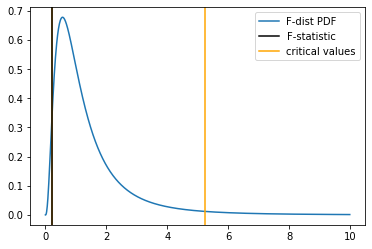

In [8]:
xrange = np.arange(0,10,0.01)
fdist = f.pdf(xrange,dof1_lp,dof2_lp)
lowerbound = f.ppf(alpha,dof1_lp,dof2_lp)
upperbound = f.ppf(1-alpha,dof1_lp,dof2_lp)

plt.plot(xrange, fdist, label = 'F-dist PDF')
plt.axvline(fstat_lp, label = 'F-statistic', color='black', zorder=10)
plt.axvline(lowerbound, label = 'critical values', color = 'orange')
plt.axvline(upperbound, color = 'orange')
plt.legend()

#### Chi-square distribution
To determine the bounds of the true population variance $\sigma$, the chi-square distribution can be used. **Again, the samples must be from an underlying normal distribution, otherwise, the test is not valid, and some sort of non-parametric test should be used instead.** <br>

95% confidence bounds on $\sigma^2$:
\begin{equation}
s^2\frac{N-1}{\chi^2_{0.975}} \le \sigma^2 \le s^2\frac{N-1}{\chi^2_{0.025}}
\end{equation}

where $\chi^2$ is the chi-square distribution, which depends on degrees of freedom $\nu$.

In [9]:
#applying to the low pass filtered version of x1
#chi2 2.5 and 97.5 percdentiles
chi2_lower = chi2.ppf(1-alpha, dof1_lp)
chi2_upper = chi2.ppf(alpha, dof1_lp)

#confidence bounds on variance
var1_lower = var1_lp * dof1_lp / chi2_lower
var1_upper = var1_lp * dof1_lp / chi2_upper

print('variance of x1:', var1_lp)
print('95% confidence bounds on variance of x1:', var1_lower, var1_upper)

variance of x1: 0.27176954758552535
95% confidence bounds on variance of x1: 0.12159093658237595 1.0531255173713834


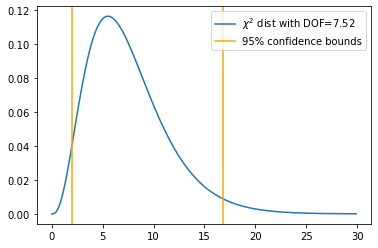

In [10]:
#visual demonstration of chi2 distribution with dof1_lp
xrange = np.arange(0,30,0.1)
plt.plot(xrange, chi2.pdf(xrange,dof1_lp), label='$\chi^2$ dist with DOF='+str(dof1_lp)[0:4])
plt.axvline(chi2_lower,color='orange', label='95% confidence bounds')
plt.axvline(chi2_upper,color='orange')
plt.legend()


#### Note for Yeager et al. (in revision):

If the LSW formation time series in Table 2 look normally distributed, then: 

1) the f-test portion of this notebook can be used to determine if the standard deviations from two of formation time series are statistically different from each other (e.g., LS+SPG-west versus SPG-east).

2) the chi-square portion of this notebook can be used to put confidence bounds on a single sample standard deviation.

If the time series do not look normally distributed, then I would just ignore trying to put confidence bounds on the standard deviations. Figuring out a more appropriate method does not seem worth it since I don't think the confidence bounds are that important for R1.

#### Footnote
The F-statistic and F-test was named for Ronald Fisher (as was the Fisher-Z transform), which are now seen as controversial choices. See: https://nautil.us/issue/92/frontiers/how-eugenics-shaped-statistics 